# Prueba técnica

### Calcular los máximos y minimos semanales y mostrar las series.

In [0]:
%matplotlib inline

# cargamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
import seaborn as sns
import datetime as dt
from fbprophet import Prophet
import scipy.stats as stats
import math
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from pylab import rcParams
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.arima_model import ARIMA


# leemos los datos
data = pd.read_csv("data.csv")
data["datetime"] = pd.to_datetime(data["datetime"], utc = True, format = '%Y-%m-%d %H:%M:%S')
data["datetime"] = pd.DatetimeIndex(data["datetime"]).tz_convert("Europe/Madrid").tz_localize(None)
data.index = data["datetime"]
data.columns = ["ds", "y"]

# configuracion
rcParams['figure.figsize'] = 14, 11
plotnine.options.figure_size = (13, 11)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [13, 11]
pd.options.mode.chained_assignment = None



def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['Hora'] = df['date'].dt.hour
    df['Día de la semana'] = df['date'].dt.day_name()
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear
    
    
    return df


In [0]:
split_date = '15-May-2019'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()


In [80]:
fig = go.Figure()
fig.add_trace(go.Scatter(x    = data_train["ds"],
                         y    = data_train["y"], 
                         mode = 'lines',
                         name = 'Train set')) 
fig.add_trace(go.Scatter(x    = data_test["ds"], 
                         y    = data_test["y"],
                         mode = 'lines',
                         name = 'Test set'))


# Edit the layout
fig.update_layout(title='Demanda eléctrica por hora',
                  xaxis_title='Fecha',
                  yaxis_title='Demanda en MW')

fig.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


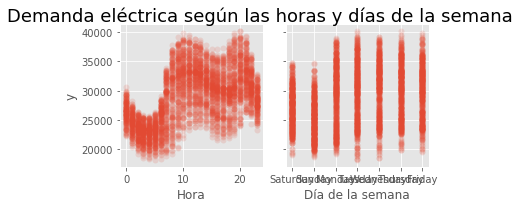

In [81]:
X = create_features(data_train)

g=sns.pairplot(X,
             x_vars=['Hora','Día de la semana'],
             y_vars='y',
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle("Demanda eléctrica según las horas y días de la semana",  y = 1.08, fontsize = 18)
plt.show()


In [82]:
fig = go.Figure()
fig.add_trace(go.Scatter(x    = data_train["ds"], 
                         y    = data_train["y"], 
                         mode = 'lines'))


shapes = list()
for i in range(7):
    shapes.append({'type': 'line',
                   'xref': 'x',
                   'yref': 'y',
                   'x0': dt.datetime(2019,2,11)+dt.timedelta(days= i*7),
                   'y0': 15000,
                   'x1': dt.datetime(2019,2,11)+dt.timedelta(days= i*7),
                   'y1': 40000})

# Edit the layout
fig.update_layout(title       = 'Demanda eléctrica por hora',
                  xaxis_title = 'Fecha',
                  yaxis_title = 'Demanda en MW',
                  shapes=shapes)

fig.show()

In [83]:
hours = 24

data_train["SMA_3"] = data_train.y.rolling(window = hours*3).mean()
data_train["EMA_3"] = data_train.y.ewm(span = hours *3, adjust=False).mean()
data_train["SMA_7"] = data_train.y.rolling(window = hours * 7).mean()
data_train["EMA_7"] = data_train.y.ewm(span = hours * 7, adjust=False).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x    = data_train["ds"],
                         y    = data_train["y"], 
                         mode = 'lines',
                         name = 'Datos originales')) 

fig.add_trace(go.Scatter(x    = data_train["ds"], 
                         y    = data_train["SMA_3"],
                         mode = 'lines',
                         name = 'SMA 3 días'))

fig.add_trace(go.Scatter(x    = data_train["ds"], 
                         y    = data_train["EMA_3"],
                         mode = 'lines',
                         name = 'EMA 3 días'))


# Edit the layout
fig.update_layout(title='Medias moviles con ventana de 3 días',
                  xaxis_title='Fecha',
                  yaxis_title='Demanda en MW')

fig.show()



In [84]:
fig = go.Figure()
fig.add_trace(go.Scatter(x    = data_train["ds"],
                         y    = data_train["y"], 
                         mode = 'lines',
                         name = 'Datos originales')) 
fig.add_trace(go.Scatter(x    = data_train["ds"], 
                         y    = data_train["SMA_7"],
                         mode = 'lines',
                         name = 'SMA 7 dias'))
fig.add_trace(go.Scatter(x    = data_train["ds"], 
                         y    = data_train["EMA_7"],
                         mode = 'lines',
                         name = 'EMA 7 dias'))


# Edit the layout
fig.update_layout(title='Medias moviles con ventana de 7 días',
                  xaxis_title='Fecha',
                  yaxis_title='Demanda en MW')

fig.show()


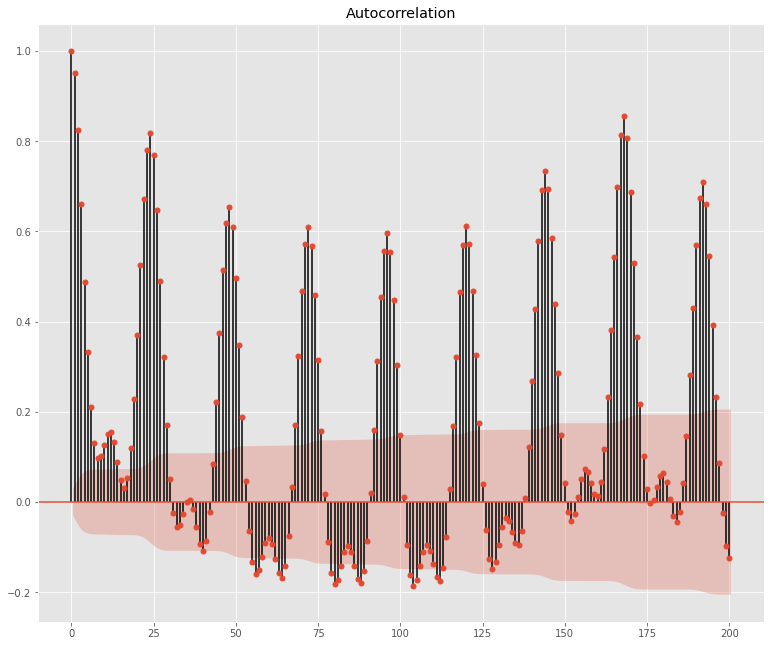

In [21]:


fig = tsaplots.plot_acf(data["y"],lags=200)


In [0]:
holidays = pd.DataFrame({
  'holiday': ["Navidad", "Navidad", 'Noche vieja' ,"Año nuevo", "Jueves santo", "Viernes santo", "Día del trabajador"],
  'ds': pd.to_datetime(['2018-12-24', '2018-12-25', '2018-12-31', '2019-01-01', 
                        '2019-04-18', '2019-04-19', '2019-05-01']),
  'lower_window': 0,
  'upper_window': 0,
})



In [85]:

model = Prophet(holidays = holidays)
model.fit(data_train)

future = model.make_future_dataframe(freq = "H", periods = 24 * 17 - 1)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


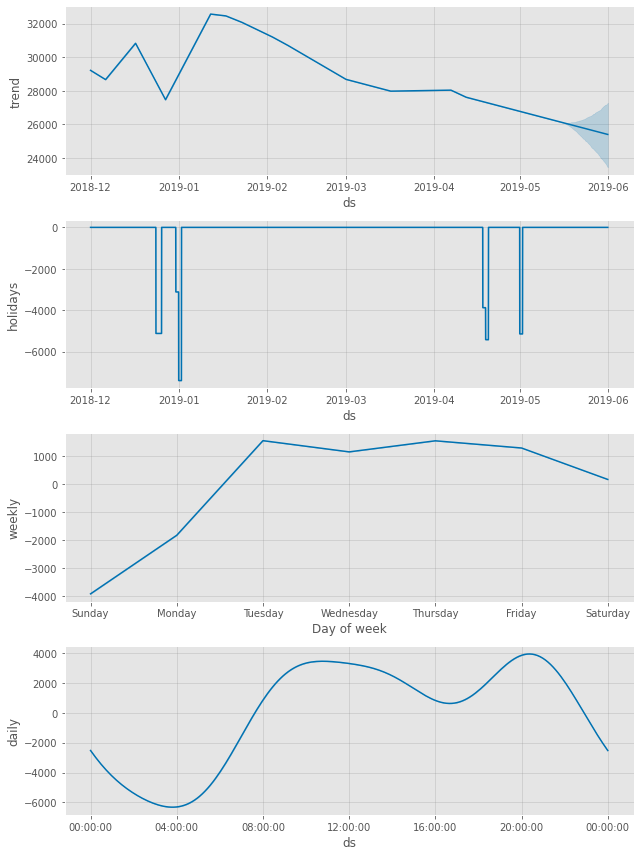

In [97]:
fig = model.plot_components(forecast)


In [34]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(model, 
                         initial = '120 days', 
                         period  = '5 days', 
                         horizon = '15 days')
df_cv

INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-03-31 00:00:00 and 2019-04-30 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-03-31 01:00:00,19102.546737,17193.610517,20893.903202,22432.441181,2019-03-31
1,2019-03-31 03:00:00,17014.620273,15205.051106,18845.328917,21540.116261,2019-03-31
2,2019-03-31 04:00:00,16711.043634,14568.619272,18784.412551,20881.649026,2019-03-31
3,2019-03-31 05:00:00,17374.566639,15530.594294,19184.003965,20626.425324,2019-03-31
4,2019-03-31 06:00:00,19218.669123,17298.734590,21173.375838,20812.678875,2019-03-31
...,...,...,...,...,...,...
2514,2019-05-14 20:00:00,30367.093421,27644.028429,33016.479921,30016.447873,2019-04-30
2515,2019-05-14 21:00:00,30094.946239,27547.054901,32601.319391,30827.933364,2019-04-30
2516,2019-05-14 22:00:00,28431.616683,25911.067516,31099.179137,29727.903071,2019-04-30
2517,2019-05-14 23:00:00,26014.116635,23266.385952,28740.508086,27211.559083,2019-04-30


In [35]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days 12:00:00,4.316133e+06,2077.530535,1546.649830,0.061212,0.044636,0.756972
1,1 days 13:00:00,4.413723e+06,2100.886209,1568.079259,0.061741,0.045533,0.756972
2,1 days 14:00:00,4.527696e+06,2127.838320,1594.207965,0.062528,0.046181,0.754126
3,1 days 15:00:00,4.599121e+06,2144.556113,1607.991948,0.062781,0.046476,0.753557
4,1 days 16:00:00,4.684056e+06,2164.268012,1624.928811,0.063184,0.046476,0.750142
...,...,...,...,...,...,...,...
320,14 days 20:00:00,9.749424e+06,3122.406824,2440.796307,0.095758,0.071377,0.702903
321,14 days 21:00:00,9.633403e+06,3103.772396,2417.115132,0.094684,0.071377,0.706887
322,14 days 22:00:00,9.528761e+06,3086.869094,2398.301478,0.093957,0.071153,0.710302
323,14 days 23:00:00,9.443437e+06,3073.017562,2387.077997,0.093682,0.069595,0.710302


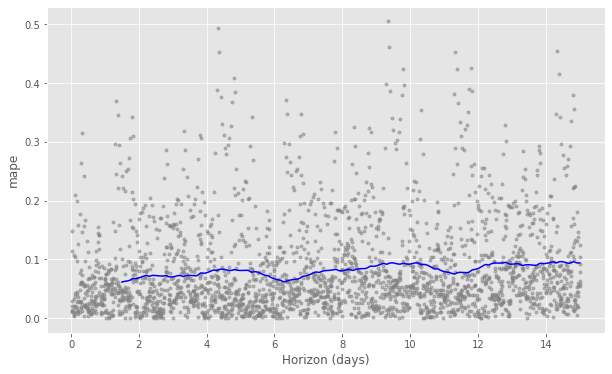

In [36]:

from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric="mape")
fig.savefig("output.png")


In [87]:
fig = go.Figure()
forecast = forecast.loc[forecast["ds"] > split_date].copy()

fig.add_trace(go.Scatter(x    = data_train["ds"],
                         y    = data_train["y"], 
                         mode = 'markers',
                         name = 'Train set')) 
fig.add_trace(go.Scatter(x    = data_test["ds"], 
                         y    = data_test["y"],
                         mode = 'markers',
                         name = 'Test set'))
fig.add_trace(go.Scatter(x    = forecast["ds"], 
                         y    = forecast["yhat"],
                         mode = 'lines',
                         line_color='black',
                         name = 'Predicción'))
fig.add_trace(go.Scatter(x=forecast["ds"], 
                         y=forecast["yhat_lower"],
                         fill=None,
                         mode='lines',
                         line_color='silver',
                         name = "Límite inferior"))
fig.add_trace(go.Scatter(x=forecast["ds"], 
                         y=forecast["yhat_upper"],
                         fill='tonexty', # fill area between trace0 and trace1
                         mode='lines', 
                         line_color='silver',
                         name = "Límite superior"))

# Edit the layout
fig.update_layout(title='Predicción de la demanda entre los días 15 y 31 de mayo',
                  xaxis_title='Fecha',
                  yaxis_title='Demanda en MW')

fig.show()


In [66]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(data_test["y"], forecast["yhat"])

5.51041712308178